# Assessing the impact of the sign and magnitude of the stress on MTPs

## Saved:
Looking again at the manual, I was doing it right to start: use the same virial\*volume as in GAP fitting \
compressed structures have positive stress, units are eV \

The mistake was being made only in the amo-starts and grouped rand-starts/10k starts. These will need repeating,
but first establish whether or not I should use numerical stresses for these (something dodgy about g18-stress)

## Test:
1. The sign of the stress calculated by mlp
2. The effect on predictions of lattice parameters (i.e. geomerty optimisations)
3. The effect on the RMSE errors on a test set (e.g. subset of melt-quench, MP and rand DBs)
4. Numerical vs. intrinsic stress predictions
5. gap18 vs. DFT stress data in original database (including for systems that don't include the stress)

In [86]:
%load_ext autoreload
%autoreload 2

In [217]:
from mtp import *
from os.path import join
from os import getcwd, chdir
from ase.io.extxyz import read_xyz, write_xyz
from quippy.potential import Potential
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from Ge_calculation import *
os.chdir('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/stress_testing')

In [25]:
GAP_18_dir = '/u/vld/hert5155/jup_remote/Ge_od/Si_GAP_training/libAtoms-silicon-testing-framework-fc252cb/models/GAP'
g18_pot = Potential(param_filename=GAP_18_dir+'/gp_iter6_sparse9k.xml')

/u/vld/hert5155/ase/ase/calculators/calculator.py:507: FutureWarning: The keyword "ignore_bad_restart_file" is deprecated and will be removed in a future version of ASE.  Passing more than one positional argument to Calculator is also deprecated and will stop functioning in the future.  Please pass arguments by keyword (key=value) except optionally the "restart" keyword.
  warnings.warn(FutureWarning(


In [95]:
with open('../GAP_18_db_GAPlabelled.pickle', 'rb') as f:
    g18_db = pickle.load(f)

# Testing set

In [7]:
mp_val_neg = list(read_cfg_db('../mp_mq_db_GAP18labelled/mp_db_GAP18labelled_validate_stressfix.cfg'))

In [10]:
mq_val_neg = list(read_cfg_db('../mqdb_GAP18labelled/mqdb_GAP18labelled_validate_stressfix.cfg'))

In [11]:
pq1k_rand_10 = list(read_cfg_db('../PQ1k_rand_10_GAP18labelled_train_stressfix_neg.cfg'))

# The sign of the stress calculated by mlp
negstress = same as gap virial and vasp, opposite of castep and ase \
posstress = same as ase and castep, opposite of vasp and mlp docs

In [90]:
neg_mtp = MTP('negstress/g18_db_negstress.mtp', parallel=False, mtp_command='/u/vld/hert5155/mlip-2/bin/mlp',
              potential_name = 'neg_sw0.001')
pos_mtp = MTP('posstress/g18_db_posstress.mtp', parallel=False, mtp_command='/u/vld/hert5155/mlip-2/bin/mlp',
              potential_name = 'pos_sw0.001')
negsw01_mtp = MTP('negstress_sw0.1/g18_db_negstress.mtp', parallel=False, mtp_command='/u/vld/hert5155/mlip-2/bin/mlp',
              potential_name = 'neg_sw0.1')
possw01_mtp = MTP('posstress_sw0.1/g18_db_posstress.mtp', parallel=False, mtp_command='/u/vld/hert5155/mlip-2/bin/mlp',
              potential_name = 'pos_sw0.1')
virial_mtp = MTP('gap_virial/g18_db_virial.mtp', parallel=False, mtp_command='/u/vld/hert5155/mlip-2/bin/mlp',
              potential_name = 'virial')

mtps = [neg_mtp, pos_mtp, negsw01_mtp, possw01_mtp, virial_mtp]
mtp_dbs = [read_cfg_db(i.potential_file[:-4]+'.cfg') for i in mtps]

In [54]:
t = mp_val_neg[0]
print(t.info['dft_virial'])

for i, val in enumerate(mtps):
    t.calc = val
    print('{:15s}'.format(val.name), t.get_stress())

[[ 0.01336674  0.00061618  0.00820008]
 [ 0.00061618  0.03674503 -0.00024105]
 [ 0.00820008 -0.00024105  0.02049803]]
neg_sw0.001     [-7.31174  8.44966 -1.49207  0.0954   8.08813  2.10125]
pos_sw0.001     [ -1.96058 -15.33326   0.63587   0.09237   6.79337   1.73468]
neg_sw0.1       [ -8.67206 -22.63583 -20.48504   0.79352   1.75752   0.34977]
pos_sw0.1       [-53.32808 -49.41287 -55.50259   0.50808   2.94087   2.10435]
virial          [  0.89854  10.46126 -10.47903  -0.84701   6.9333    0.29264]


# The effect on predictions of lattice parameters

# The effect on the RMSE errors on a test set 
(e.g. subset of melt-quench, MP and rand DBs)

labelling with the mtps

In [62]:
mp_err = [np.zeros((len(mp_val_neg), 3, 3)) for i in mtps]

for i, val in enumerate(mtps):
    for act, at in enumerate(mp_val_neg):
        val.calculate(at)
        mp_err[i][act] = abs(val.results['stress']) - abs(at.info['dft_virial']) # stress direct from mlp - mp_neg convention

In [69]:
mp_pred = [np.zeros((len(mp_val_neg), 3, 3)) for i in mtps]
for i, val in enumerate(mtps):
    for act, at in enumerate(mp_val_neg):
        val.calculate(at)
        mp_pred[i][act] = val.results['stress']

In [64]:
mp_p_err = np.array([[160.218*i.trace()/3 for i in j] for j in mp_err])

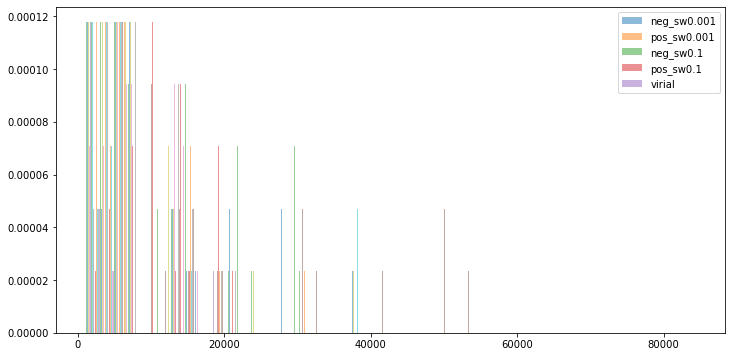

In [73]:
fig, axs = plt.subplots(figsize=(12,6))
#errs = mp_p_err
h = axs.hist(errs, label=[i.name for i in mtps], bins=10, density=True, alpha=1.0)
axs.legend()

In [68]:
[i.mean() for i in mp_p_err], [i.name for i in mtps]

([11824.141081344942,
  11470.643104241095,
  8396.676785093556,
  7553.427204071095,
  11422.219647137556],
 ['neg_sw0.001', 'pos_sw0.001', 'neg_sw0.1', 'pos_sw0.1', 'virial'])

# Numerical stress prediction

numerical stresses are clearly more reasonable than the 'in-house' stresses of all MTPs above. 

g18 stresses are quite similar (see rms error between them)

In [75]:
at.calc = mtps[0]

mtps[0].calculate_numerical_forces(at)

array([[ 0.08699673,  0.02883274, -0.16120175],
       [-0.22791936, -0.20137656,  0.026972  ],
       [-0.00349318,  0.05527904,  0.14066297],
       [-0.23465   , -0.07671041,  0.18172184],
       [-0.46670317,  0.36788179,  0.04247484],
       [ 0.3066669 , -0.2366682 , -0.00377405],
       [-0.08253442,  0.36312688, -0.08018249],
       [ 0.36355284, -0.07447302,  0.12803645],
       [ 0.24833386,  0.16660853,  0.22268548],
       [ 0.07699785, -0.23283208,  0.24080542],
       [-0.03120508,  0.06079989, -0.25250507],
       [-0.01225799, -0.36752151,  0.00910356],
       [-0.03395584,  0.16923254,  0.30969042],
       [-0.0827583 , -0.30674595,  0.27181014],
       [ 0.07305994,  0.17672152, -0.2717617 ],
       [ 0.30932237, -0.04792577, -0.35143204],
       [-0.09421123,  0.08811123, -0.08649779],
       [-0.02665475,  0.05313742, -0.21890564],
       [-0.0951211 , -0.16223686,  0.14302761],
       [ 0.08066653, -0.05389065, -0.0849266 ],
       [ 0.06630705,  0.1023059 ,  0.006

In [78]:
nforce = mtps[0].results['forces'].copy()

In [80]:
mtps[0].calculate(at)
aforce = mtps[0].results['forces'].copy()

In [82]:
(nforce-aforce).max()

0.011704999999999993

In [97]:
mtps[0].calculate_numerical_stress(at), at.get_stress(), g18_pot.calculate_numerical_stress(at)

(array([ 0.01370315,  0.0263111 ,  0.03311319, -0.00386621, -0.00108595,
         0.00262134]),
 array([-35.44933, -73.44567, -88.55248,  10.97407,   3.07274,  -7.3789 ]),
 array([ 0.01370315,  0.0263111 ,  0.03311319, -0.00386621, -0.00108595,
         0.00262134]))

In [98]:
at.calc = g18_pot
g18_pot.calculate_numerical_stress(at), at.get_stress()

(array([-0.00889701,  0.00199347,  0.00694842, -0.00339159, -0.00107564,
         0.00207664]),
 array([-0.00891206,  0.00199905,  0.00694674, -0.00339052, -0.00106689,
         0.00206633]))

In [226]:
mp_stress_g18 = np.zeros((len(mp_val_neg), 6))

In [ ]:
mp_numstress_mtp = [np.zeros((len(mp_val_neg), 6)) for i in mtps]
mp_numstress_g18 = np.zeros((len(mp_val_neg), 6))

In [242]:
for i, val in enumerate(mp_val_neg):
#     for j, m in enumerate(mtps):
#         val.calc = m
#         mp_numstress_mtp[j][i] = m.calculate_numerical_stress(val)
        
#     val.calc = g18_pot
#     mp_numstress_g18[i] = g18_pot.calculate_numerical_stress(val)
#     val.calc = None

    mp_stress_g18[i] = -1*to_voigt(val.info['dft_virial'])
    
    

In [233]:
mp_val_neg[50].info, mp_stress_g18[0]

({'dft_energy': -37802.794426690525,
  'dft_virial': array([[ 0.01700269, -0.00034999,  0.00932616],
         [-0.00034999,  0.05485084,  0.00236875],
         [ 0.00932616,  0.00236875,  0.02845539]]),
  'config_type': 'mp-1201492',
  'cutoff': '5.0',
  'nneightol': '1.2'},
 array([13.02480096, 35.80504311, 19.97366305, -0.23488362,  7.99031101,
         0.60041729]))

In [ ]:
g18_numstress_mtp = [np.zeros((len(g18_db), 6)) for i in mtps]
g18_stress_dft = np.zeros((len(g18_db), 6))
g18_numstress_g18 = np.zeros((len(g18_db), 6))
g18_stress_mtp = [np.zeros((len(g18_db), 6)) for i in mtps]

In [163]:
def to_voigt(mat):
    
    vgt = np.concatenate((mat.diagonal(), np.array([mat[1,2], mat[0,2], mat[0,1]])))
    return vgt

In [218]:
for i, val in enumerate(g18_db):
    for j, m in enumerate(mtps):
        val.calc = m
#         g18_numstress_mtp[j][i] = -1*m.calculate_numerical_stress(val)
        g18_stress_mtp[j][i] = -1*val.get_stress()/val.get_volume()
        
        
#     val.calc = g18_pot
#     g18_numstress_g18[i] = g18_pot.calculate_numerical_stress(val)
#     val.calc = None

#     g18_stress_g18[i] = to_voigt(val.info['gap18_virial']/val.get_volume())
    
#     try:
#         g18_stress_dft[i] = to_voigt(val.info['dft_virial'].reshape((3,3)))/val.get_volume()
#     except:
#         g18_stress_dft[i] = np.NaN

In [109]:
# os.makedirs('tmp_python')

In [111]:
# with open('tmp_python/mp_numstress_mtp.pickle', 'wb') as f:
#     pickle.dump(mp_numstress_mtp, f)
# with open('tmp_python/mp_numstress_g18.pickle', 'wb') as f:
#     pickle.dump(mp_numstress_g18, f)

In [245]:
with open('tmp_python/mp_numstress_g18.pickle', 'rb') as f:
    mp_numstress_g18 = pickle.load(f)

In [146]:
# with open('tmp_python/g18_numstress_mtp.pickle', 'wb') as f:
#     pickle.dump(g18_numstress_mtp, f)


In [214]:
# with open('tmp_python/g18_numstress_g18.pickle', 'wb') as f:
#     pickle.dump(g18_numstress_g18, f)

# Absolute numerical stress-errors of MTPs vs. GAP

In [240]:
mp_numstress_g18

array([[-0.01334916, -0.03673683, -0.02049156,  0.0002377 , -0.00819273,
        -0.00061733],
       [-0.00603779, -0.0037085 , -0.00553657,  0.00069976,  0.00290588,
        -0.00023997],
       [ 0.02678525, -0.01716057,  0.01683868, -0.0033921 ,  0.00239003,
        -0.00013543],
       ...,
       [-0.00956304, -0.0113472 , -0.00953746,  0.00945297,  0.00656085,
        -0.0022161 ],
       [ 0.02371803,  0.02086983,  0.01755399,  0.00536775,  0.00472656,
         0.00170249],
       [-0.00888596,  0.00200047,  0.00695217, -0.00338822, -0.00108063,
         0.00207819]])

[Text(0.5, 0, 'abs stress error / GPa'),
 Text(0, 0.5, 'Normalised count'),
 (-1.0, 25.0)]

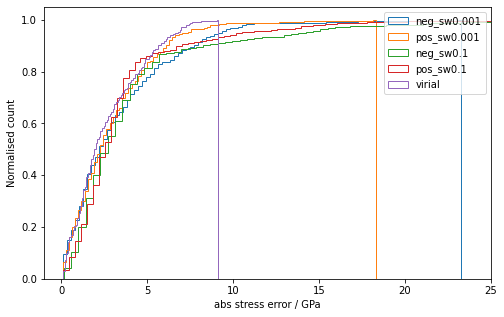

In [141]:
fig, axs = plt.subplots(figsize=(8,5))

for i, val in enumerate(mtps[0:5]):
    h = axs.hist(abs(mp_numstress_mtp[i] - mp_numstress_g18)[:,0:3].mean(axis=1)*160,
                 label=[i.name for i in mtps][i],
                 bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')

axs.legend()
axs.set(xlabel='abs stress error / GPa', ylabel='Normalised count', xlim=(-1, 25))


In [246]:
mp_stress_g18[50], mp_numstress_g18[50]

(array([-0.01700269, -0.05485084, -0.02845539, -0.00236875, -0.00932616,
         0.00034999]),
 array([-0.01699081, -0.0548507 , -0.0284436 , -0.0023692 , -0.00933132,
         0.00033933]))

[Text(0.5, 0, 'abs stress error / GPa'), Text(0, 0.5, 'Normalised count')]

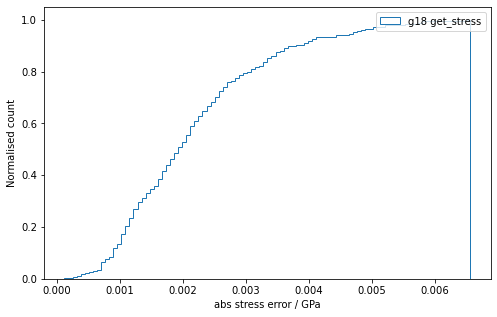

In [247]:
fig, axs = plt.subplots(figsize=(8,5))


h = axs.hist(abs(mp_stress_g18 - mp_numstress_g18)[:,0:3].mean(axis=1)*160,
             label='g18 get_stress',
             bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')

axs.legend()
axs.set(xlabel='abs stress error / GPa', ylabel='Normalised count')#, xlim=(-1, 25))


# Numerical stress errors of MTPs vs. DFT - g18 db

In [187]:
abs(mp_numstress_mtp[i] - mp_numstress_g18)[:,0:3]

array([[0.01232653, 0.02487557, 0.03172225],
       [0.00985187, 0.02703166, 0.03145197],
       [0.00296486, 0.01814643, 0.02171659],
       ...,
       [0.02189121, 0.02134353, 0.0194187 ],
       [0.02718131, 0.02739553, 0.02963814],
       [0.02436997, 0.02533127, 0.02812906]])

In [215]:
g18_stress_dft[50], g18_numstress_g18[50], g18_stress_g18[50], g18_numstress_mtp[0][50]

(array([ 0.1082662 ,  0.02537806,  0.08442323, -0.03214011,  0.01234281,
         0.01404406]),
 array([ 0.10875015,  0.02719445,  0.07955753, -0.03054093,  0.00428213,
         0.00943229]),
 array([ 0.10886669,  0.02703487,  0.07946011, -0.03042996,  0.00438229,
         0.00933422]),
 array([-0.0697438 ,  0.00222842, -0.04291709,  0.03389305, -0.00382245,
         0.00554765]))

[Text(0.5, 0, 'abs stress error / GPa'),
 Text(0, 0.5, 'Normalised count'),
 (-1.0, 25.0)]

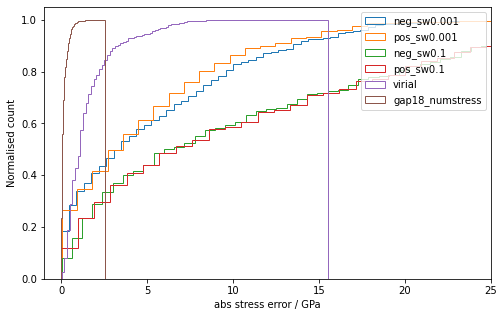

In [213]:
fig, axs = plt.subplots(figsize=(8,5))

for i, val in enumerate(mtps[0:5]):
    h = axs.hist(abs(-g18_numstress_mtp[i] - g18_stress_dft)[:,0:3].mean(axis=1)*160,
                 label=[i.name for i in mtps][i],
                 bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')
h = axs.hist(abs(g18_numstress_g18 - g18_stress_dft)[:,0:3].mean(axis=1)*160,
             label='gap18_numstress',
             bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')
axs.legend()
axs.set(xlabel='abs stress error / GPa', ylabel='Normalised count', xlim=(-1, 25))

[Text(0.5, 0, 'abs stress error / GPa'), Text(0, 0.5, 'Normalised count')]

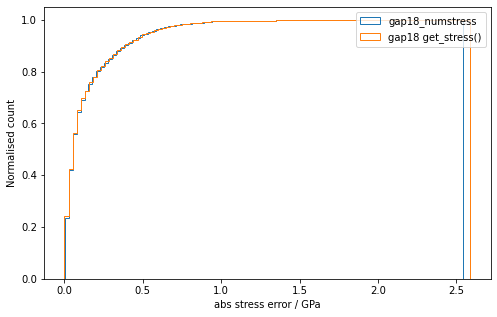

In [210]:
fig, axs = plt.subplots(figsize=(8,5))

h = axs.hist(abs(g18_numstress_g18 - g18_stress_dft)[:,0:3].mean(axis=1)*160,
             label='gap18_numstress',
             bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')

h = axs.hist(abs(g18_stress_g18 - g18_stress_dft)[:,0:3].mean(axis=1)*160,
             label='gap18 get_stress()',
             bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')

axs.legend()
axs.set(xlabel='abs stress error / GPa', ylabel='Normalised count')#, xlim=(-1, 50))

[Text(0.5, 0, 'abs stress error / GPa'), Text(0, 0.5, 'Normalised count')]

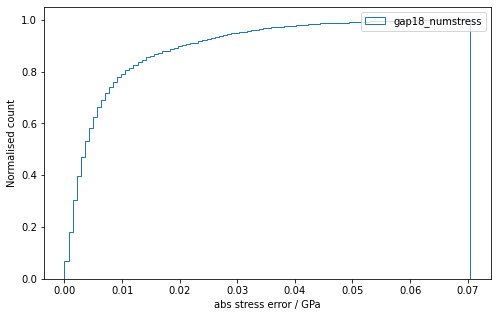

In [248]:
fig, axs = plt.subplots(figsize=(8,5))

h = axs.hist(abs(g18_numstress_g18 - g18_stress_g18)[:,0:3].mean(axis=1)*160,
             label='gap18_numstress',
             bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')
axs.legend()
axs.set(xlabel='abs stress error / GPa', ylabel='Normalised count')#, xlim=(-1, 50))

[Text(0.5, 0, 'abs stress error / GPa'),
 Text(0, 0.5, 'Normalised count'),
 (-1.0, 25.0)]

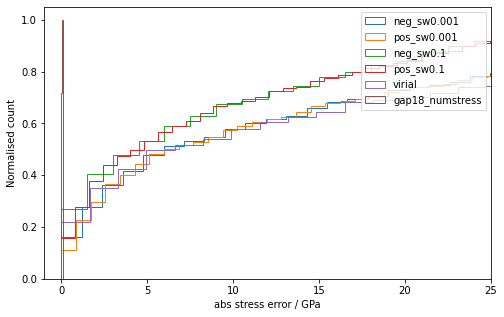

In [211]:
fig, axs = plt.subplots(figsize=(8,5))

for i, val in enumerate(mtps[0:5]):
    h = axs.hist(abs(g18_numstress_mtp[i] - g18_stress_g18)[:,0:3].mean(axis=1)*160,
                 label=[i.name for i in mtps][i],
                 bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')
h = axs.hist(abs(g18_numstress_g18 - g18_stress_g18)[:,0:3].mean(axis=1)*160,
             label='gap18_numstress',
             bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')
axs.legend()
axs.set(xlabel='abs stress error / GPa', ylabel='Normalised count', xlim=(-1, 25))

In [ ]:
fig, axs = plt.subplots(figsize=(8,5))

for i, val in enumerate(mtps[0:5]):
    h = axs.hist(abs(g18_numstress_mtp[i] - g18_stress_dft)[:,0:3].mean(axis=1)*160,
                 label=[i.name for i in mtps][i],
                 bins=100, density=True, alpha=1.0, cumulative=True, histtype='step')

axs.legend()
axs.set(xlabel='abs stress error / GPa', ylabel='Normalised count', xlim=(-1, 25))